# Telecom Churn Prediction - Submission by Satya Prakash & Mythili Kandula

For this case study, we are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [110]:
#!pip install missingno

In [138]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [139]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")

print(data.shape)
print(unseen.shape)

(69999, 172)
(30000, 171)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables. 

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [140]:
data.shape

(69999, 172)

In [141]:
data.head(10)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.00,0.00,0.00,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.00,0.00,0.00,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.00,0.00,0.00,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.00,0.00,0.00,0
5,5,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,86.193,83.351,...,0,0,NaN,NaN,NaN,698,0.00,0.00,0.00,0
6,6,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,54.173,95.130,...,0,0,NaN,NaN,NaN,1083,0.00,0.00,0.00,0
7,7,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,167.861,167.869,...,0,0,1.0,1.0,1.0,584,82.26,73.56,177.14,0
8,8,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,163.550,90.250,...,0,0,NaN,NaN,NaN,2455,0.00,0.00,0.00,1
9,9,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,101.984,259.265,...,0,0,NaN,NaN,NaN,2530,0.00,0.00,0.00,0


In [142]:
# feature type summary
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [143]:
# look at data statistics
data.describe(include='all')

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
unique,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,69999,69600,69266,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34999.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,283.134365,278.185912,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,NaN,NaN,NaN,334.213918,344.366927,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,-2258.709000,-1289.715000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,93.581000,86.714000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,197.484000,191.588000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,370.791000,365.369500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000


In [144]:
# create backup of data
original = data.copy()

In [145]:
data.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)

In [146]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

data = data[variables].set_index('id')

In [147]:
data.shape

(69999, 24)

In [148]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


Let's look at each variable's datatype:

In [149]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        69999 no

Let's also summarize the features using the df.describe method:

In [150]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [21]:
data['circle_id'].unique()

array([109], dtype=int64)

In [22]:
X = data.drop(['circle_id'],axis=1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 22), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #split in 70(train):30(test)% ratio

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48999, 22), (21000, 22), (48999,), (21000,))

In [24]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
50873,110,110,130,104.76,92.63,90.81,96.39,84.59,86.21,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,878
35919,267,177,328,256.11,231.18,24.88,163.09,152.84,20.54,NaN,...,NaN,NaN,0.0,0.0,0.0,121.6,0.0,0.0,103.7,1209
26255,0,410,560,0.00,456.88,591.53,NaN,13.39,40.51,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,208
66996,365,365,485,95.29,151.43,223.28,91.16,143.59,216.84,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,426
17102,50,120,130,66.26,83.79,100.76,31.86,42.26,71.74,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2578


# 2. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

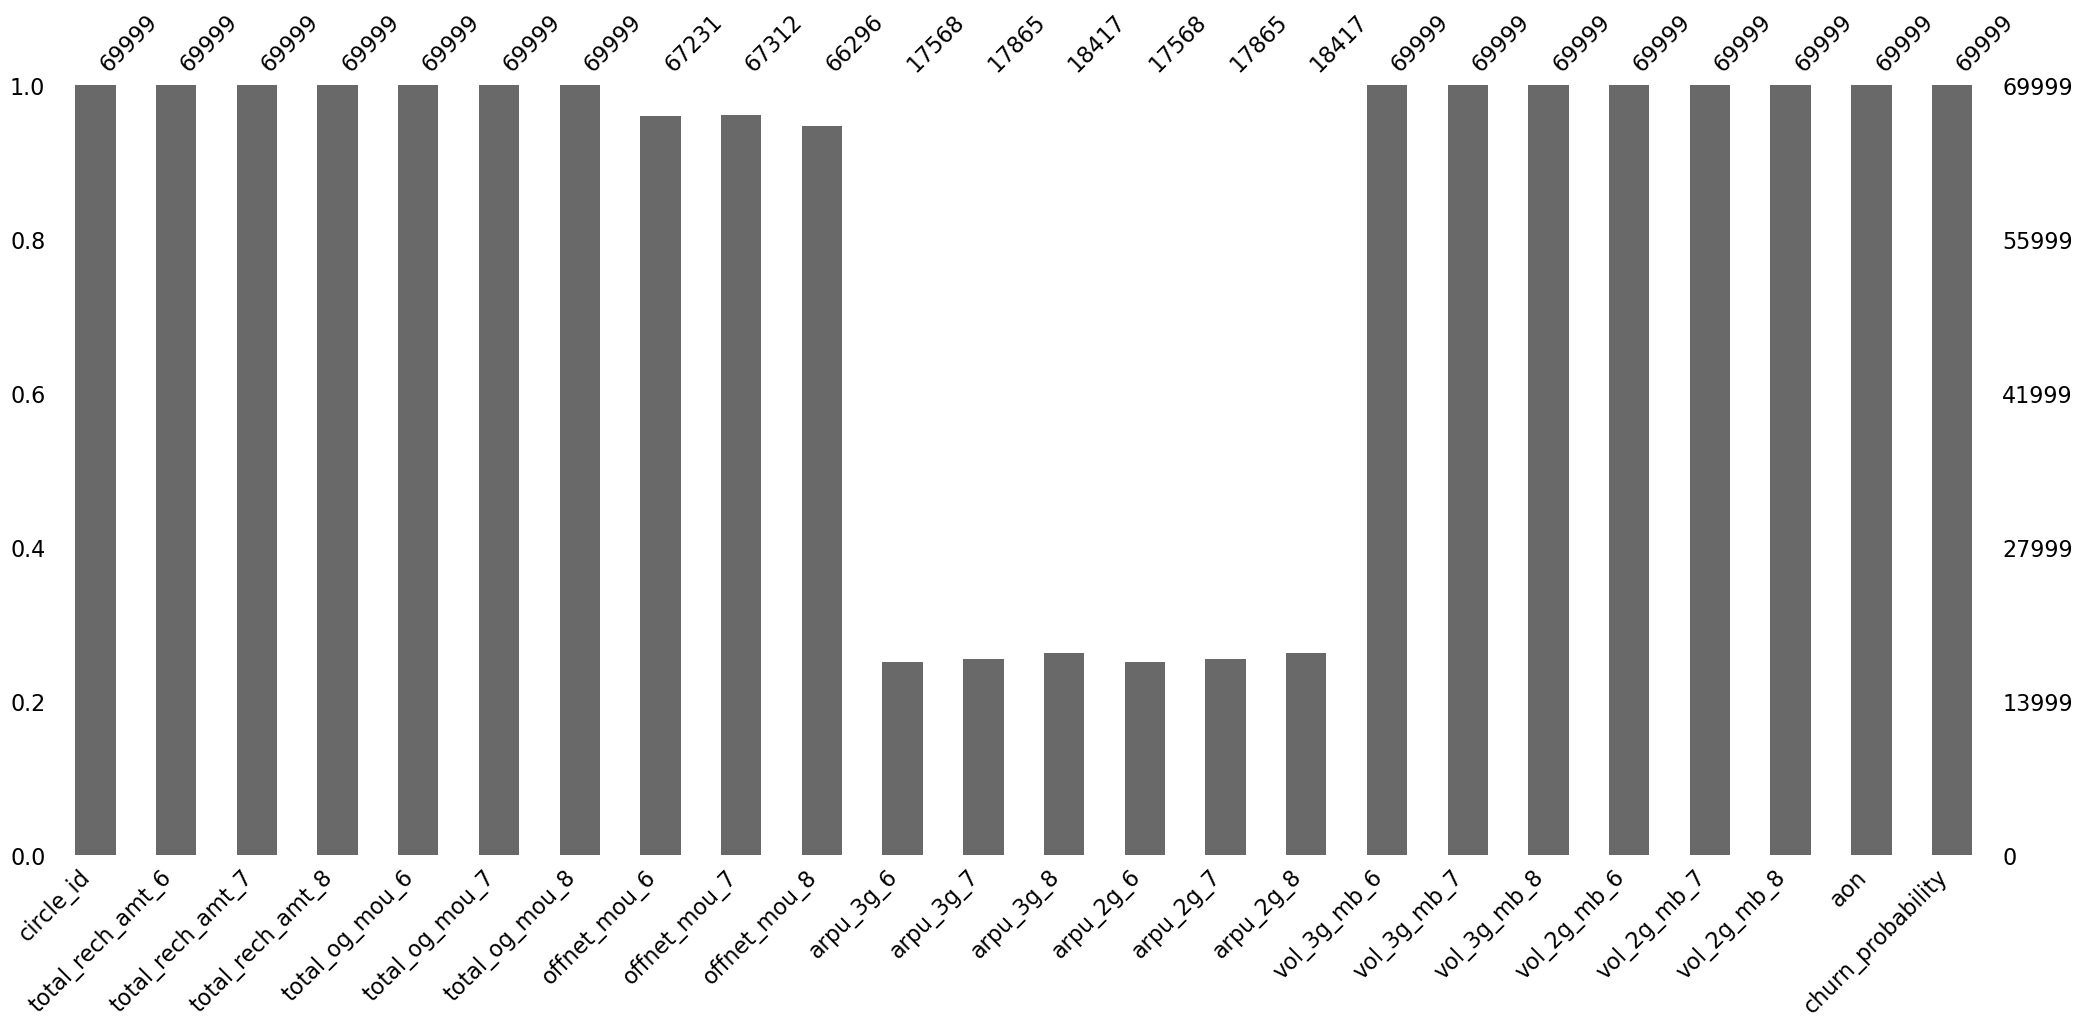

In [151]:
msno.bar(data)

<Axes: >

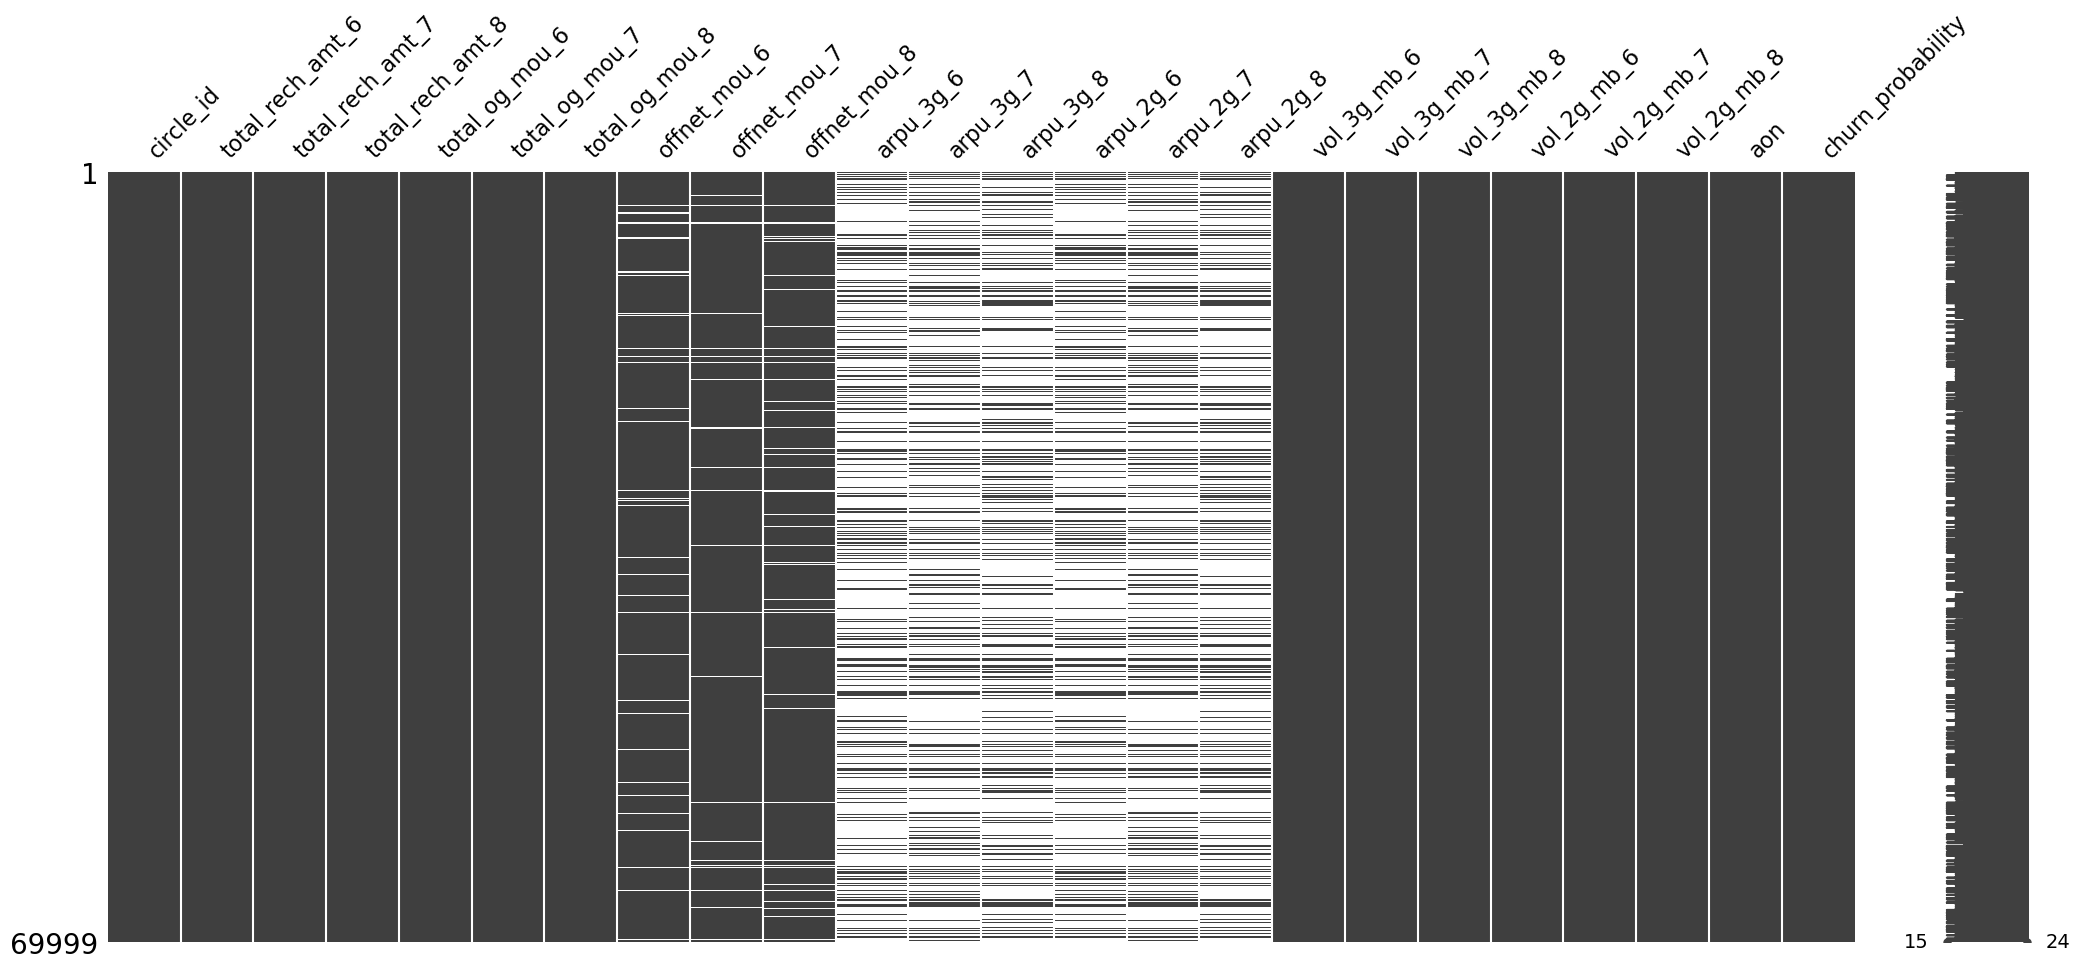

In [152]:
msno.matrix(data)

Lets also calculate the % missing data for each column:

In [154]:
missing_data_percent_data = 100*data.isnull().sum()/len(data)
missing_data_percent_data

circle_id             0.000000
total_rech_amt_6      0.000000
total_rech_amt_7      0.000000
total_rech_amt_8      0.000000
total_og_mou_6        0.000000
total_og_mou_7        0.000000
total_og_mou_8        0.000000
offnet_mou_6          3.954342
offnet_mou_7          3.838626
offnet_mou_8          5.290076
arpu_3g_6            74.902499
arpu_3g_7            74.478207
arpu_3g_8            73.689624
arpu_2g_6            74.902499
arpu_2g_7            74.478207
arpu_2g_8            73.689624
vol_3g_mb_6           0.000000
vol_3g_mb_7           0.000000
vol_3g_mb_8           0.000000
vol_2g_mb_6           0.000000
vol_2g_mb_7           0.000000
vol_2g_mb_8           0.000000
aon                   0.000000
churn_probability     0.000000
dtype: float64

We see that the columns with 2g and 3g information has more than 70% missing value. It is probably due to the reason than these customer are not generating any average revenue(ARPU) for mobile data. It would be interesting to see if these cusomers have any data volume value or not.

In [155]:
data[data['arpu_3g_6'].isnull() & data['vol_3g_mb_6'] > 0].head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,


In [156]:
# We can see that there is no internet data usage for these customers. we can impute these missing values with zero
data.arpu_3g_6.fillna(0, inplace=True)
data.arpu_3g_7.fillna(0, inplace=True)
data.arpu_3g_8.fillna(0, inplace=True)
data.arpu_2g_6.fillna(0, inplace=True)
data.arpu_2g_7.fillna(0, inplace=True)
data.arpu_2g_8.fillna(0, inplace=True)

In [157]:
data.isnull().sum()

circle_id               0
total_rech_amt_6        0
total_rech_amt_7        0
total_rech_amt_8        0
total_og_mou_6          0
total_og_mou_7          0
total_og_mou_8          0
offnet_mou_6         2768
offnet_mou_7         2687
offnet_mou_8         3703
arpu_3g_6               0
arpu_3g_7               0
arpu_3g_8               0
arpu_2g_6               0
arpu_2g_7               0
arpu_2g_8               0
vol_3g_mb_6             0
vol_3g_mb_7             0
vol_3g_mb_8             0
vol_2g_mb_6             0
vol_2g_mb_7             0
vol_2g_mb_8             0
aon                     0
churn_probability       0
dtype: int64

In [158]:
# we can see that for 6th and 7th month missing values are much lesser than 8th month. Lets see what is the overlap between these missing values.
data[data['offnet_mou_6'].isnull() & data['offnet_mou_8'].isnull()].shape

(893, 24)

In [159]:
data[data['offnet_mou_7'].isnull() & data['offnet_mou_8'].isnull()].shape

(1619, 24)

In [160]:
data[data['offnet_mou_6'].isnull() & data['offnet_mou_7'].isnull()].shape

(1247, 24)

In [161]:
data[data['offnet_mou_6'].isnull() & data['offnet_mou_7'].isnull() & data['offnet_mou_8'].isnull()].shape

(758, 24)

We can see that there are 758 rows with all three month values as null, we can first impute these with zero and for the remaining rows we can impute with value(s) from other months.

In [162]:
data.loc[data['offnet_mou_6'].isnull() & data['offnet_mou_7'].isnull() & data['offnet_mou_8'].isnull(), 'offnet_mou_6'] = 0

In [163]:
data.loc[(data['offnet_mou_6'] == 0) & data['offnet_mou_7'].isnull() & data['offnet_mou_8'].isnull(), 'offnet_mou_7'] = 0

In [164]:
data.loc[(data['offnet_mou_6'] == 0) & (data['offnet_mou_7'] == 0) & data['offnet_mou_8'].isnull(), 'offnet_mou_8'] = 0

In [165]:
data[data['offnet_mou_6'].isnull() & data['offnet_mou_7'].isnull() & data['offnet_mou_8'].isnull()].shape

(0, 24)

In [167]:
data.isnull().sum()

circle_id               0
total_rech_amt_6        0
total_rech_amt_7        0
total_rech_amt_8        0
total_og_mou_6          0
total_og_mou_7          0
total_og_mou_8          0
offnet_mou_6         2010
offnet_mou_7         1881
offnet_mou_8         2845
arpu_3g_6               0
arpu_3g_7               0
arpu_3g_8               0
arpu_2g_6               0
arpu_2g_7               0
arpu_2g_8               0
vol_3g_mb_6             0
vol_3g_mb_7             0
vol_3g_mb_8             0
vol_2g_mb_6             0
vol_2g_mb_7             0
vol_2g_mb_8             0
aon                     0
churn_probability       0
dtype: int64

Now the remaining rows have either of the three month columns as valid value. We will take the value and impute other columns for the same customer

In [168]:
# Iterate through each row in the DataFrame
for index, row in data.iterrows():
    if np.isnan(row['offnet_mou_6']):  # Check if offnet_mou_6 is null
        if row['offnet_mou_7'] != 0:
            if row['offnet_mou_8'] != 0:
                data.at[index, 'offnet_mou_6'] = (row['offnet_mou_7'] + row['offnet_mou_8']) / 2  # Impute with average value
            else:
                data.at[index, 'offnet_mou_6'] = row['offnet_mou_7']
        else:
            if row['offnet_mou_8'] != 0:
                data.at[index, 'offnet_mou_6'] = row['offnet_mou_8']
            else:
                data.at[index, 'offnet_mou_6'] = 0

    if np.isnan(row['offnet_mou_7']):  # Check if offnet_mou_7 is null
        if row['offnet_mou_6'] != 0:
            if row['offnet_mou_8'] != 0:
                data.at[index, 'offnet_mou_7'] = (row['offnet_mou_6'] + row['offnet_mou_8']) / 2  # Impute with average value
            else:
                data.at[index, 'offnet_mou_7'] = row['offnet_mou_6']
        else:
            if row['offnet_mou_8'] != 0:
                data.at[index, 'offnet_mou_7'] = row['offnet_mou_8']
            else:
                data.at[index, 'offnet_mou_7'] = 0

    if np.isnan(row['offnet_mou_8']):  # Check if offnet_mou_8 is null
        if row['offnet_mou_7'] != 0:
            if row['offnet_mou_8'] != 0:
                data.at[index, 'offnet_mou_8'] = (row['offnet_mou_7'] + row['offnet_mou_6']) / 2  # Impute with average value
            else:
                data.at[index, 'offnet_mou_8'] = row['offnet_mou_7']
        else:
            if row['offnet_mou_8'] != 0:
                data.at[index, 'offnet_mou_8'] = row['offnet_mou_6']
            else:
                data.at[index, 'offnet_mou_8'] = 0


In [169]:
#Impute remaining rows with zeroes
data.offnet_mou_6.fillna(0, inplace=True)
data.offnet_mou_7.fillna(0, inplace=True)
data.offnet_mou_8.fillna(0, inplace=True)

In [170]:
data.isnull().sum()

circle_id            0
total_rech_amt_6     0
total_rech_amt_7     0
total_rech_amt_8     0
total_og_mou_6       0
total_og_mou_7       0
total_og_mou_8       0
offnet_mou_6         0
offnet_mou_7         0
offnet_mou_8         0
arpu_3g_6            0
arpu_3g_7            0
arpu_3g_8            0
arpu_2g_6            0
arpu_2g_7            0
arpu_2g_8            0
vol_3g_mb_6          0
vol_3g_mb_7          0
vol_3g_mb_8          0
vol_2g_mb_6          0
vol_2g_mb_7          0
vol_2g_mb_8          0
aon                  0
churn_probability    0
dtype: int64

In [175]:
data_vars = data.columns
data_vars

Index(['circle_id', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'churn_probability'],
      dtype='object')

In [176]:
data.shape

(69999, 24)

In [177]:
data.describe()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,194.909468,190.675754,191.044655,...,21.909458,22.718590,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,314.498088,318.581050,320.400431,...,97.431711,95.265909,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,32.010000,27.810000,27.830000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,93.140000,86.610000,87.410000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,228.270000,219.515000,222.145000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


In [178]:
data.head(100)

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.240,96.68,2.33,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.000,25.99,30.89,...,122.08,0.0,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.990,82.05,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.760,78.48,50.23,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.990,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,109,0,0,250,0.00,26.24,205.13,103.945,21.03,186.86,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,3234,0
96,109,1017,0,617,1138.79,792.69,620.43,960.780,706.88,548.19,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,943,0
97,109,560,237,140,580.46,329.59,117.71,175.910,102.54,62.99,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,1145,0


# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [179]:
data['circle_id'].unique()

array([109], dtype=int64)

In [180]:
X = data.drop(['circle_id'],axis=1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 22), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #split in 70(train):30(test)% ratio

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48999, 22), (21000, 22), (48999,), (21000,))

In [182]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
35347,200,350,426,487.54,62.08,740.71,233.54,90.910,71.46,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,607
44333,252,86,252,0.16,35.04,0.00,0.16,34.160,17.16,212.17,...,212.27,1060.85,424.34,1232.29,5157.96,2518.08,22.39,28.74,23.06,247
55338,154,110,80,199.91,136.53,135.64,10.36,34.590,33.74,0.00,...,8.12,0.02,10.01,0.00,0.00,0.00,525.47,747.10,469.36,2372
3078,75,0,476,0.00,0.00,424.86,0.00,0.000,81.03,21.91,...,21.82,0.00,0.00,167.48,0.00,0.00,176.30,0.00,0.00,226
12755,840,0,713,1771.63,0.00,1200.26,11.31,29.675,48.04,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,327


In [183]:
new_vars = X_train.columns
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [184]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(48999, 22)

In [185]:
X_train_filtered.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
count,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,...,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000
mean,329.029409,324.024511,324.981918,307.422987,310.557951,303.678716,195.109031,190.212700,190.473764,22.846356,...,22.115511,22.276269,23.176693,123.202588,130.470176,136.835828,51.819986,51.721499,50.357514,1218.252964
std,421.676046,430.539161,449.086799,469.961181,478.794850,473.315716,319.187597,321.120885,322.745769,104.642341,...,94.701659,100.753406,96.785454,570.166187,570.155360,588.492262,213.978368,213.916867,216.034000,952.188689
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-20.380000,...,-15.320000,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000
25%,110.000000,100.000000,90.000000,44.710000,42.220000,38.360000,31.787500,27.530000,27.485000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,467.000000
50%,228.000000,220.000000,224.000000,145.140000,140.790000,137.760000,92.880000,86.010000,86.540000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,865.000000
75%,436.000000,430.000000,436.000000,373.335000,380.175000,369.965000,227.395000,218.085000,221.445000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1808.000000
max,35190.000000,40335.000000,45320.000000,8488.360000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,5054.370000,...,5054.350000,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

count    48999.000000
mean        22.846356
std        104.642341
min        -20.380000
25%          0.000000
50%          0.000000
75%          0.000000
max       5054.370000
Name: arpu_3g_6, dtype: float64

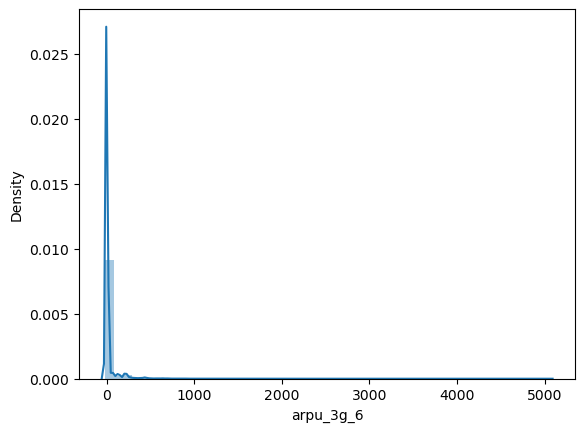

In [186]:
sns.distplot(X_train_filtered['arpu_3g_6'])
X_train_filtered['arpu_3g_6'].describe()

count    48999.000000
mean      1218.252964
std        952.188689
min        180.000000
25%        467.000000
50%        865.000000
75%       1808.000000
max       4337.000000
Name: aon, dtype: float64

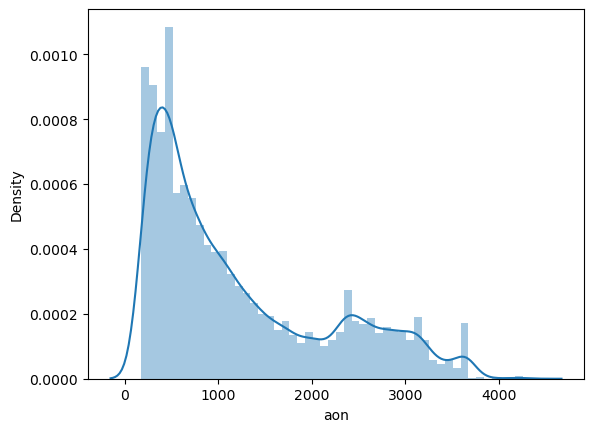

In [187]:
sns.distplot(X_train_filtered['aon'])
X_train_filtered['aon'].describe()

count    48999.000000
mean        22.115511
std         94.701659
min        -15.320000
25%          0.000000
50%          0.000000
75%          0.000000
max       5054.350000
Name: arpu_2g_6, dtype: float64

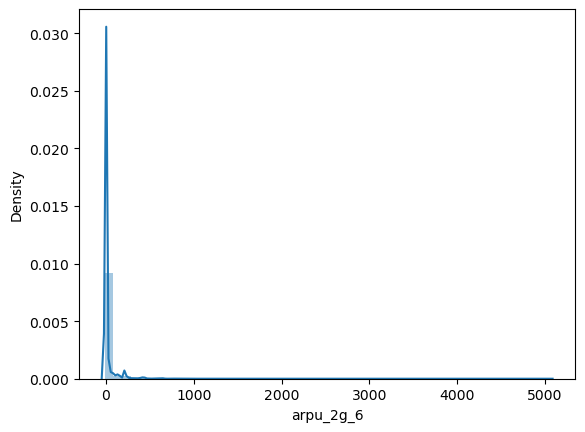

In [188]:
sns.distplot(X_train_filtered['arpu_2g_6'])
X_train_filtered['arpu_2g_6'].describe()

count    48999.000000
mean       123.202588
std        570.166187
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      45735.400000
Name: vol_3g_mb_6, dtype: float64

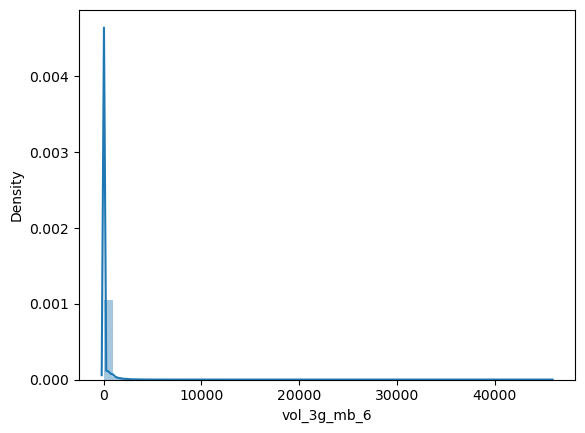

In [189]:
sns.distplot(X_train_filtered['vol_3g_mb_6'])
X_train_filtered['vol_3g_mb_6'].describe()

count    48999.000000
mean        51.819986
std        213.978368
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      10285.900000
Name: vol_2g_mb_6, dtype: float64

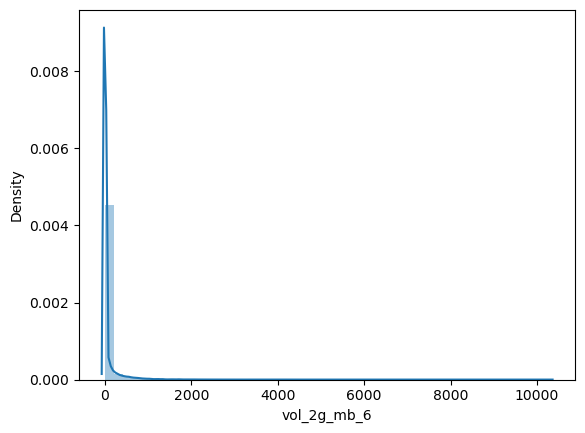

In [190]:
sns.distplot(X_train_filtered['vol_2g_mb_6'])
X_train_filtered['vol_2g_mb_6'].describe()

count    48999.000000
mean       329.029409
std        421.676046
min          0.000000
25%        110.000000
50%        228.000000
75%        436.000000
max      35190.000000
Name: total_rech_amt_6, dtype: float64

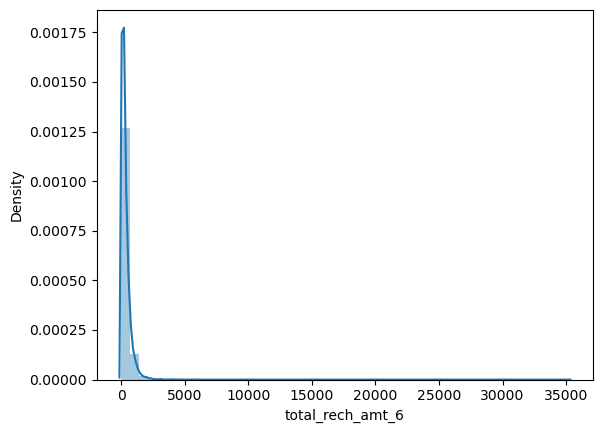

In [191]:
sns.distplot(X_train_filtered['total_rech_amt_6'])
X_train_filtered['total_rech_amt_6'].describe()

Variables are very **skewed** towards the left.

## Bivariate EDA

<Axes: >

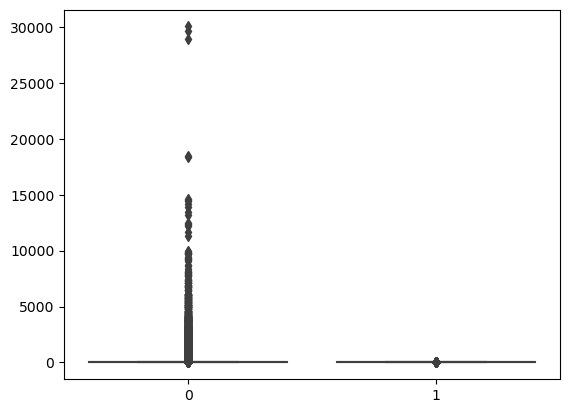

In [192]:
sns.boxplot(data = (data.vol_3g_mb_8, data.churn_probability))

<Axes: >

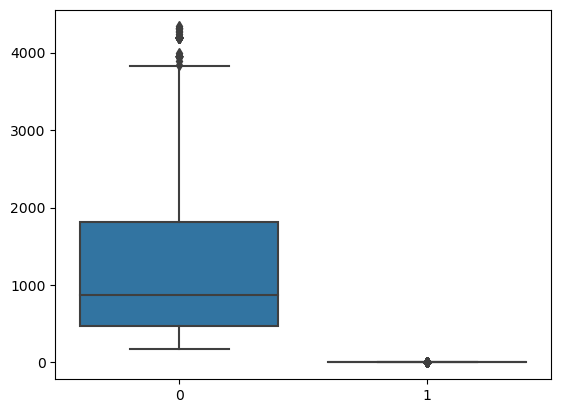

In [193]:
# sns.boxplot(data = (data['aon'], data['churn_probability']))
sns.boxplot(data = (data.aon, data.churn_probability))

In [194]:
pd.crosstab(data.churn_probability, data.total_rech_amt_6, normalize='columns')*100

total_rech_amt_6,0,7,9,10,12,14,15,17,18,19,...,6549,7300,7560,9856,11900,12000,12795,13096,17840,35190
churn_probability,,,,,,,,,,,,,,,,,,,,,
0,85.778347,90.909091,66.666667,92.307692,100.0,94.444444,84.210526,91.304348,85.714286,100.0,...,100.0,100.0,100.0,100.0,0.0,0.0,100.0,100.0,100.0,100.0
1,14.221653,9.090909,33.333333,7.692308,0.0,5.555556,15.789474,8.695652,14.285714,0.0,...,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0


In [195]:
pd.crosstab(data.churn_probability, data.aon, normalize='columns')*100

aon,180,181,182,183,184,185,186,187,188,189,...,4193,4195,4197,4235,4260,4282,4299,4319,4321,4337
churn_probability,,,,,,,,,,,,,,,,,,,,,
0,77.083333,84.42623,76.190476,83.783784,76.829268,80.681818,80.898876,85.882353,75.0,81.690141,...,90.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,22.916667,15.57377,23.809524,16.216216,23.170732,19.318182,19.101124,14.117647,25.0,18.309859,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
pd.crosstab(data.churn_probability, data.total_og_mou_8, normalize='columns')*100

total_og_mou_8,0.00,0.01,0.03,0.05,0.06,0.08,0.10,0.11,0.13,0.15,...,7460.53,7697.53,7739.51,7818.01,7885.29,8212.53,8309.78,10882.86,11046.74,14043.06
churn_probability,,,,,,,,,,,,,,,,,,,,,
0,41.851617,81.25,46.153846,83.333333,50.0,100.0,55.555556,100.0,100.0,70.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,58.148383,18.75,53.846154,16.666667,50.0,0.0,44.444444,0.0,0.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

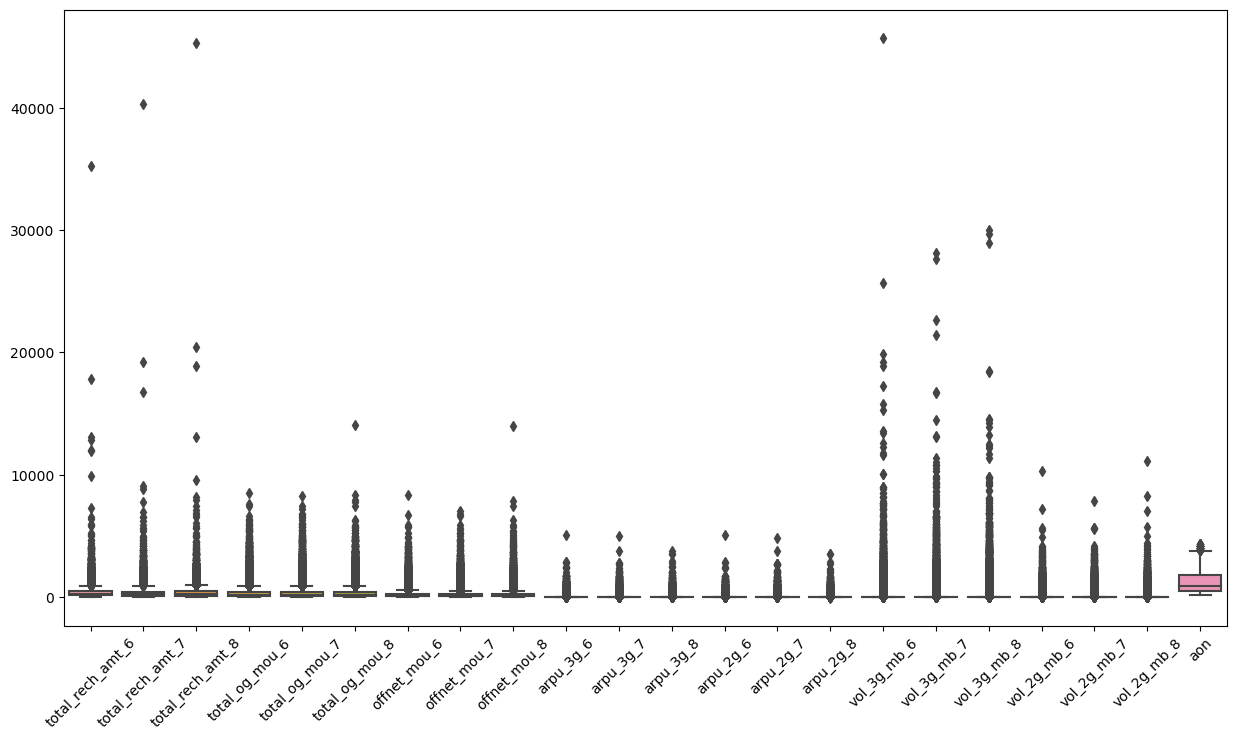

In [197]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [198]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

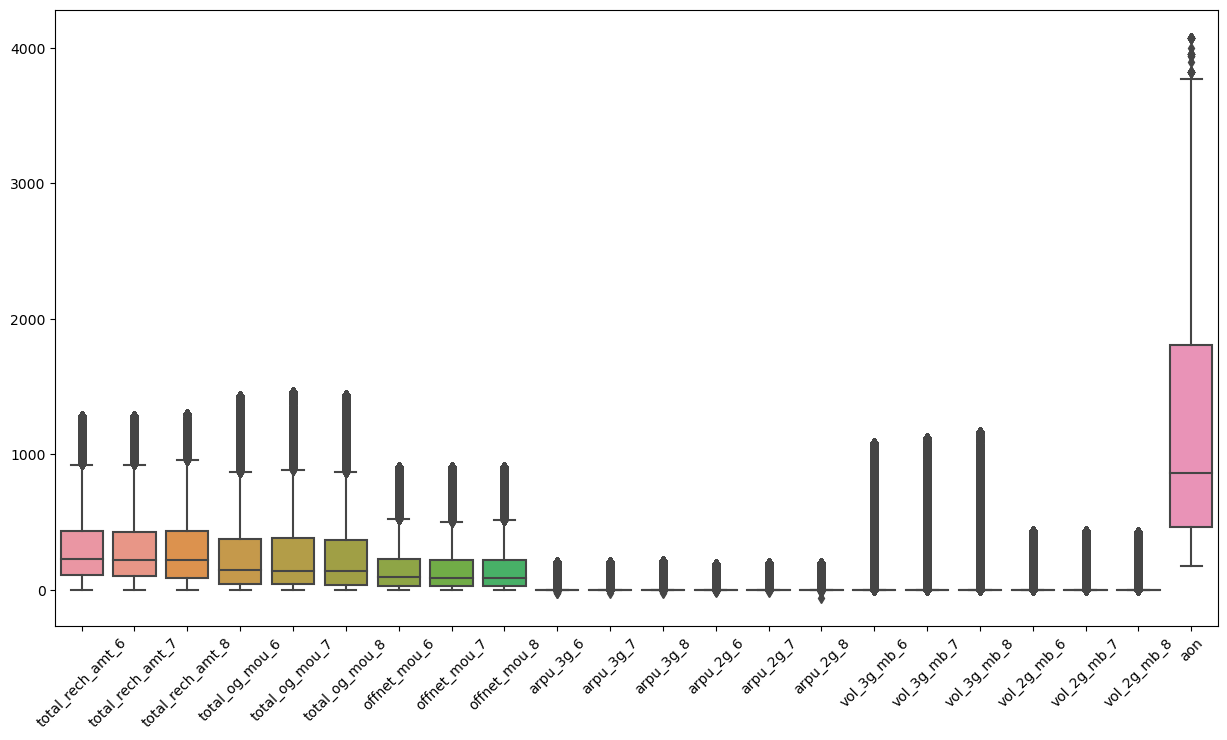

In [200]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

In [201]:
X_train_filtered1.shape

(48999, 22)

In [202]:
X_train_filtered1.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
count,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,...,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000
mean,314.048198,308.751753,309.598912,283.117399,286.263629,279.663326,176.015684,171.208582,172.190513,14.467897,...,14.707686,14.598895,15.670595,85.579868,90.613685,96.303978,34.302904,33.789729,32.732095,1218.161624
std,301.350835,302.548265,305.313951,353.541608,362.356504,356.149469,218.403494,219.536663,219.476640,47.464463,...,45.211004,45.761226,48.108793,253.983323,264.388471,275.320681,99.943494,99.092245,96.530437,951.907677
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-20.380000,...,-15.320000,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000
25%,110.000000,100.000000,90.000000,44.710000,42.220000,38.360000,31.787500,27.530000,27.485000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,467.000000
50%,228.000000,220.000000,224.000000,145.140000,140.790000,137.760000,92.880000,86.010000,86.540000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,865.000000
75%,436.000000,430.000000,436.000000,373.335000,380.175000,369.965000,227.395000,218.085000,221.445000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1808.000000
max,1280.966423,1283.949290,1299.693852,1430.809940,1459.153548,1434.614702,907.435840,905.692402,905.264817,203.729304,...,190.786859,195.047609,199.733862,1083.750469,1121.591974,1161.541883,436.673718,433.889910,428.295679,4073.890906


In [203]:
X_train_filtered1.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
35347,200.0,350.0,426.0,487.54000,62.08,740.71,233.54,90.910,71.46,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,607.0
44333,252.0,86.0,252.0,0.16000,35.04,0.00,0.16,34.160,17.16,203.729304,...,190.786859,195.047609,199.733862,1083.750469,1121.591974,1161.541883,22.390000,28.74000,23.060000,247.0
55338,154.0,110.0,80.0,199.91000,136.53,135.64,10.36,34.590,33.74,0.000000,...,8.120000,0.020000,10.010000,0.000000,0.000000,0.000000,436.673718,433.88991,428.295679,2372.0
3078,75.0,0.0,476.0,0.00000,0.00,424.86,0.00,0.000,81.03,21.910000,...,21.820000,0.000000,0.000000,167.480000,0.000000,0.000000,176.300000,0.00000,0.000000,226.0
12755,840.0,0.0,713.0,1430.80994,0.00,1200.26,11.31,29.675,48.04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,327.0


### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [204]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<Axes: >

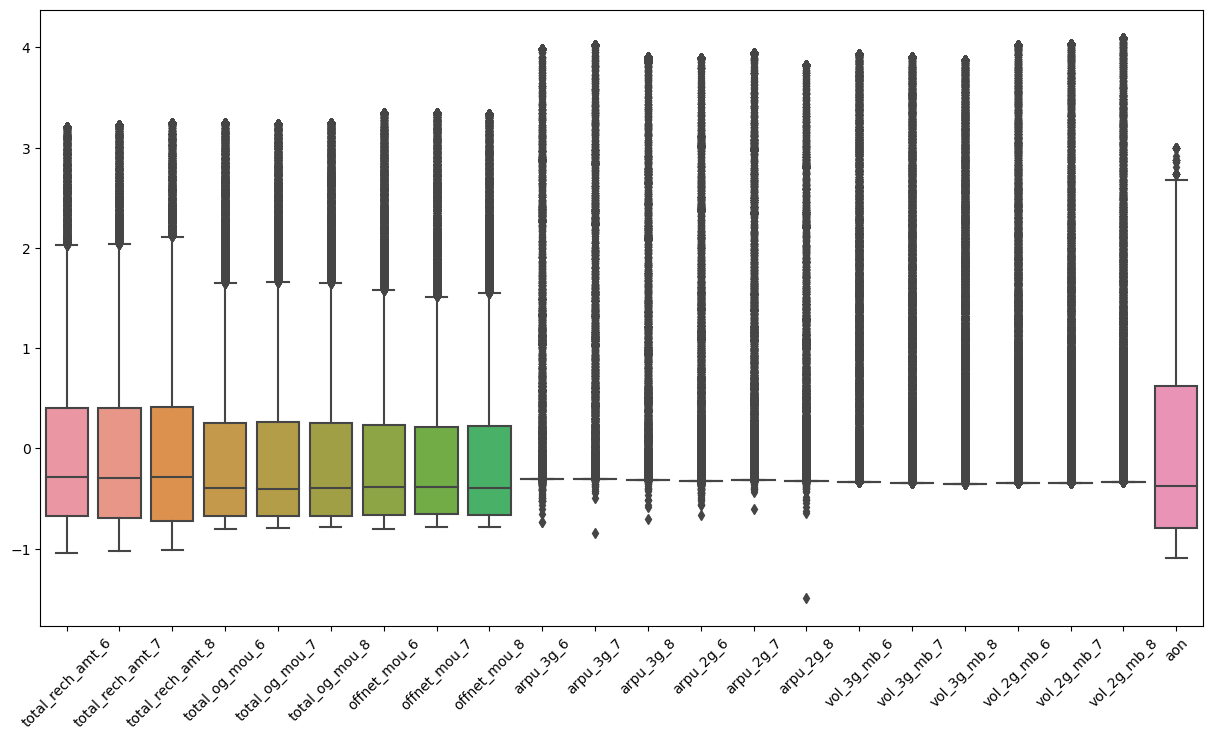

In [205]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

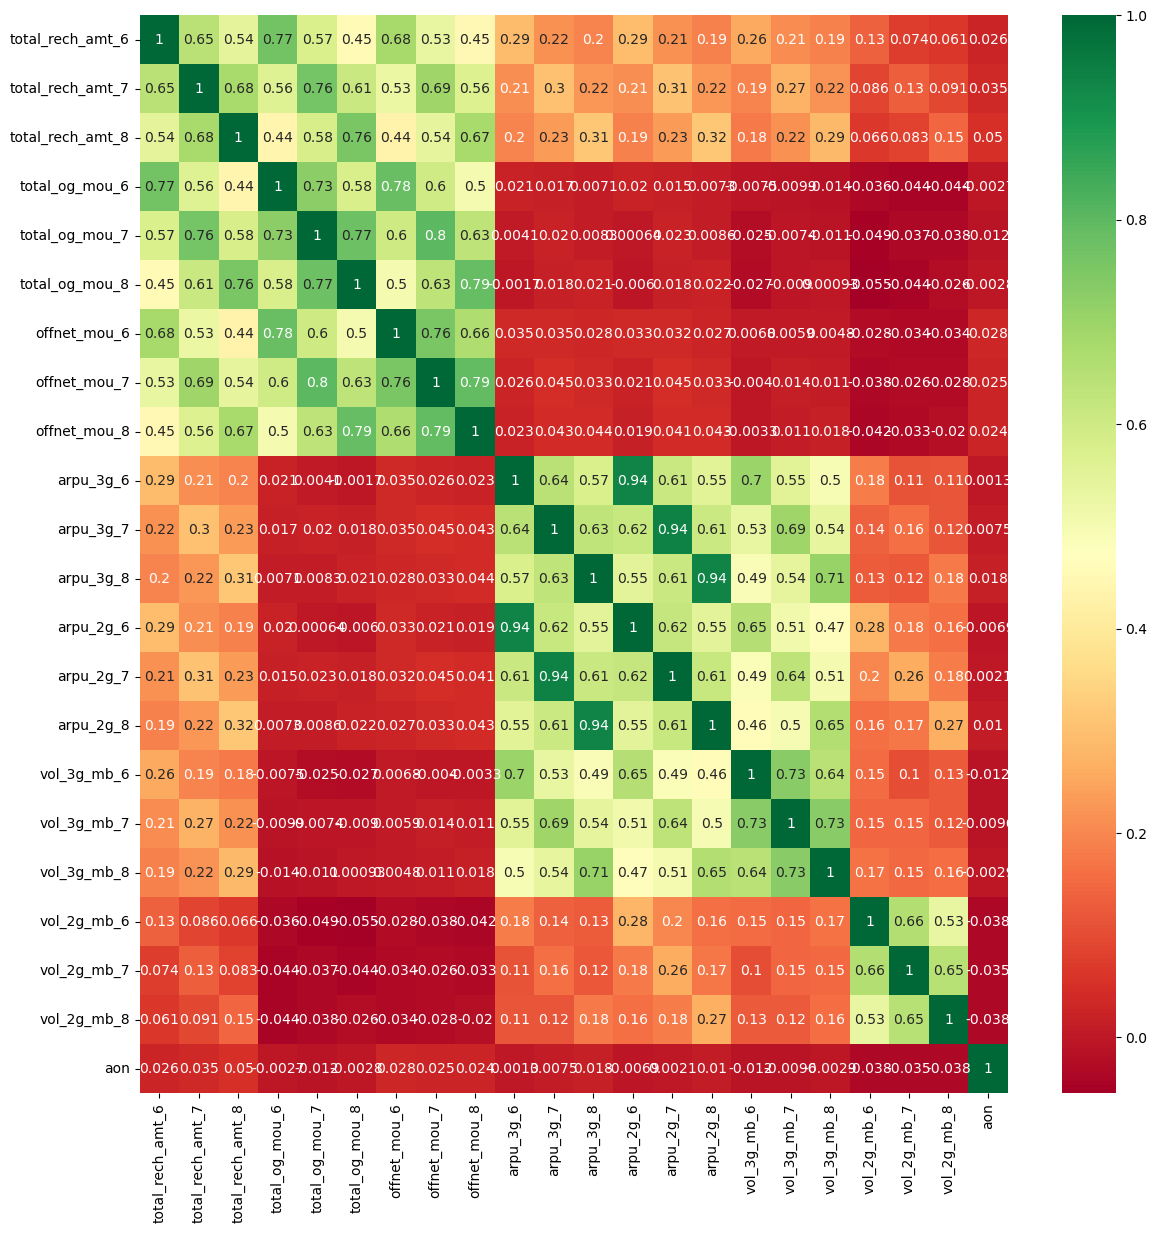

In [206]:
plt.figure(figsize=(14,14))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr(), cmap='RdYlGn', annot=True)

In [207]:
X_train_filtered2.shape

(48999, 22)

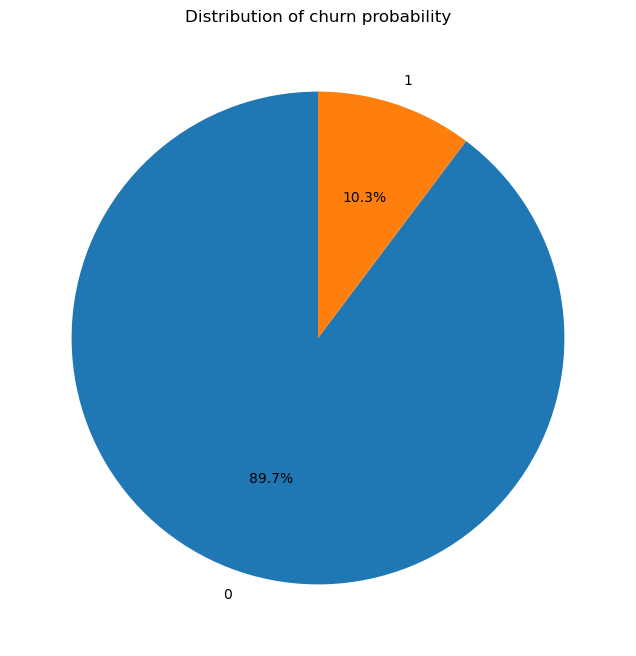

In [208]:
#Distribution for the churn probability
#sns.histplot(y_train)
unique_labels, label_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of churn probability")
plt.show()

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [209]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [210]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 22 artists>

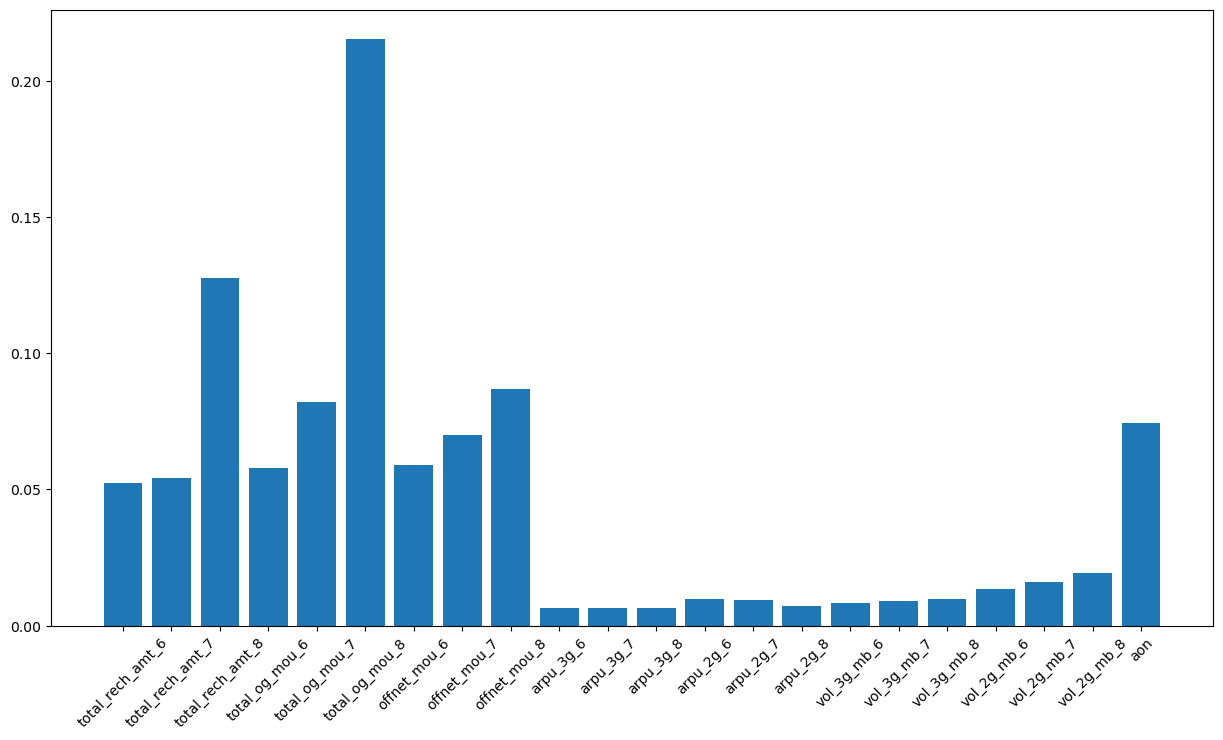

In [211]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

<Axes: >

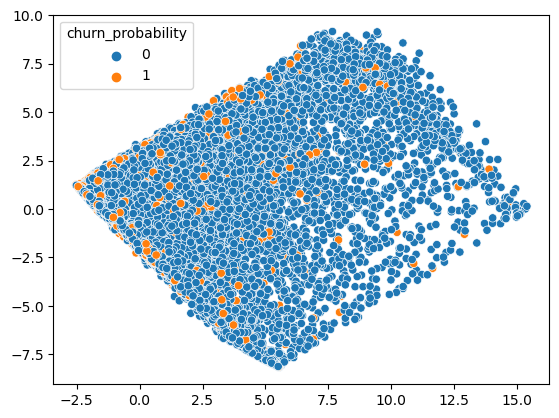

In [212]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

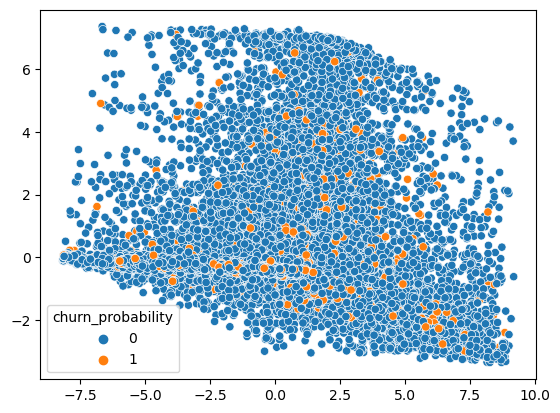

In [213]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

<BarContainer object of 22 artists>

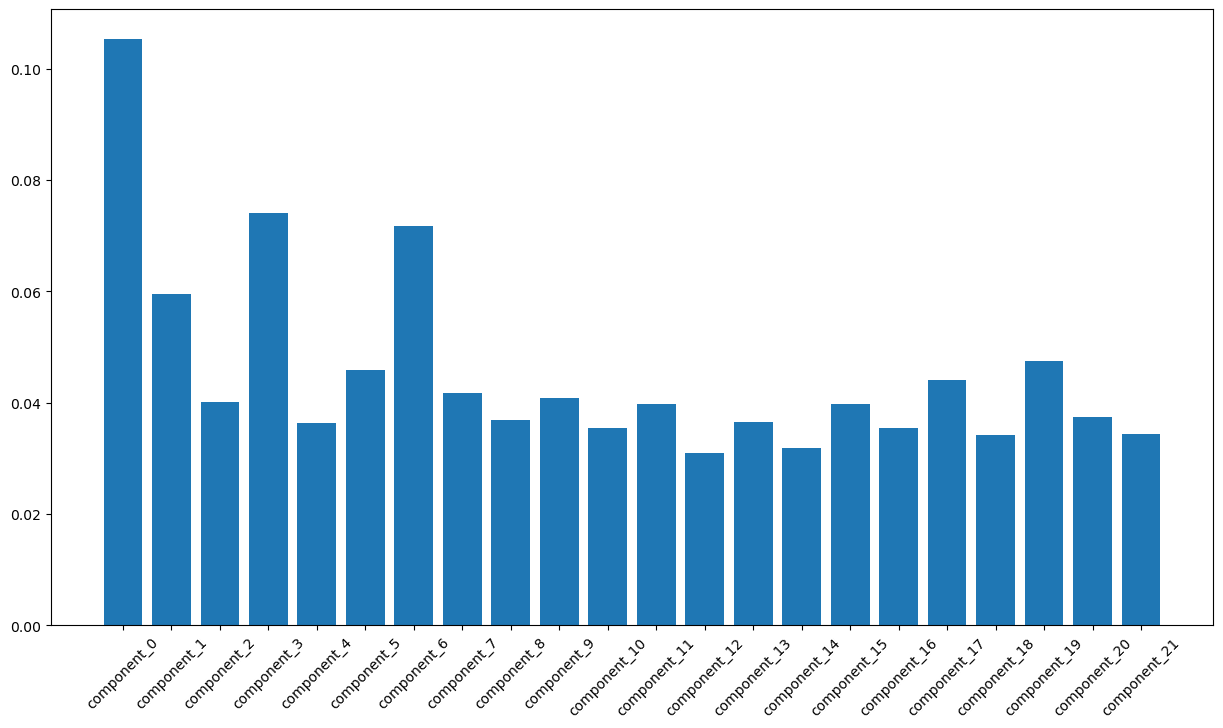

In [214]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(22)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [215]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [216]:
lr.score(pca_components[:,:2], y_train)

0.8974060695116227

The model has 89.74% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [217]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [218]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [219]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [220]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.8981815955427662


In [221]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9002857142857142


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [222]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[43754,   218],
       [ 4771,   256]], dtype=int64)

In [223]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[18806,    89],
       [ 2005,   100]], dtype=int64)

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Handling class imbalance in classification models will be the next step

In [224]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.5291005291005291

In [225]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.047505938242280284

In [226]:
X_train_filtered2.shape, X_test[new_vars].shape, y_train.shape, y_test.shape

((48999, 22), (21000, 22), (48999,), (21000,))

### Hyperparameter tuning - PCA and Logistic Regression

In [227]:
# class imbalance
y_train.value_counts()/y_train.shape

churn_probability
0    0.897406
1    0.102594
Name: count, dtype: float64

In [228]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

# create pipeline
steps = [("imputation",SimpleImputer(strategy='constant', fill_value=0)),
        ("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [10, 12], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [229]:
# fit model
model.fit(X_train[new_vars], y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('imputation',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [10, 12]},
             scoring='roc_auc', verbose=1)

In [230]:
# cross validation results
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.431522,0.023656,0.000000,0.000000,0.1,l1,10,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
1,1.324878,0.122989,0.000000,0.000000,0.1,l1,12,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2,1.214825,0.133540,0.045868,0.018656,0.1,l2,10,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.791448,0.792383,0.780624,0.801424,0.781036,0.789383,0.007806,16
3,1.440405,0.260512,0.083596,0.045146,0.1,l2,12,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.810299,0.809125,0.807436,0.819541,0.799254,0.809131,0.006483,8
4,1.192756,0.111819,0.000000,0.000000,0.5,l1,10,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
5,1.448720,0.132041,0.000000,0.000000,0.5,l1,12,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
6,1.195389,0.149842,0.057658,0.011858,0.5,l2,10,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.791529,0.792454,0.780717,0.801511,0.781119,0.789466,0.007804,15
7,1.398350,0.069289,0.059003,0.006962,0.5,l2,12,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.810540,0.809376,0.807803,0.819737,0.799456,0.809382,0.006474,7
8,1.087076,0.137850,0.000000,0.000000,1,l1,10,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
9,1.295915,0.113652,0.000000,0.000000,1,l1,12,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17


In [231]:
train_score1 = model.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score1)

Training accuracy: 0.8101852154284267


In [232]:
test_score1 = model.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score1)

Test accuracy: 0.8060624818112849


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [233]:
confusion_matrix(y_train, model.predict(X_train[new_vars]))

array([[29260, 14712],
       [ 1040,  3987]], dtype=int64)

In [234]:
confusion_matrix(y_test, model.predict(X_test[new_vars]))

array([[12653,  6242],
       [  451,  1654]], dtype=int64)

In [235]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8094459509177284
Best hyperparameters:  {'logistic__C': 10, 'logistic__penalty': 'l2', 'pca__n_components': 12}


In [236]:
precision_score(y_test, model.predict(X_test[new_vars]))

0.20947315096251268

In [237]:
recall_score(y_test, model.predict(X_test[new_vars]))

0.7857482185273159

In [238]:
# check area under curve
y_pred_prob = model.predict_proba(X_test[new_vars])[:, 1]
print("AUC: ", round(roc_auc_score(y_test, y_pred_prob),2))

AUC:  0.81


The best model is PCA along with Logistic regression.

### Choosing best features

In [239]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train[new_vars].shape[1])))    # number of variables to consider to split each node
print(max_features)

5


In [240]:
rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

In [241]:
# fit model
rf_model.fit(X_train[new_vars], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   28.7s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=5,
                       oob_score=True, random_state=4, verbose=1)

In [242]:
# OOB score
rf_model.oob_score_

0.9355701136757893

In [243]:
X_test[new_vars].columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [244]:
X_train[new_vars].columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [245]:
# predict churn on test data
y_pred = rf_model.predict(X_test[new_vars])

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test[new_vars])[:, 1]
print("ROC: ", round(roc_auc_score(y_test, y_pred_prob),2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[18566   329]
 [  967  1138]]
ROC:  0.9


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


### Feature Importance

In [246]:
# predictors
features = X_train[new_vars].columns
# data.drop(['circle_id'],axis=1).columns
print(features)

# feature_importance
importance = rf_model.feature_importances_
print(importance)

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')
[0.04067329 0.05069814 0.13616748 0.05396675 0.08812233 0.27671938
 0.04614161 0.0582356  0.07535757 0.004607   0.00532927 0.00575191
 0.0071096  0.00727133 0.00972976 0.00541209 0.00649091 0.01205791
 0.00906744 0.01102629 0.0225979  0.06746644]
Sum of importance= 99.99999999999999


,variables,importance_percentage
0,total_og_mou_8,27.671938
1,total_rech_amt_8,13.616748
2,total_og_mou_7,8.812233
3,offnet_mou_8,7.535757
4,aon,6.746644
5,offnet_mou_7,5.823560
6,total_og_mou_6,5.396675
7,total_rech_amt_7,5.069814
8,offnet_mou_6,4.614161
9,total_rech_amt_6,4.067329


In [247]:
# Consider Top 10 features
top_features = ['total_og_mou_8', 'total_rech_amt_8', 'total_og_mou_7', 'offnet_mou_8', 'aon', 'offnet_mou_7', 
                'total_og_mou_6', 'total_rech_amt_7', 'offnet_mou_6', 'total_rech_amt_6']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

<Axes: >

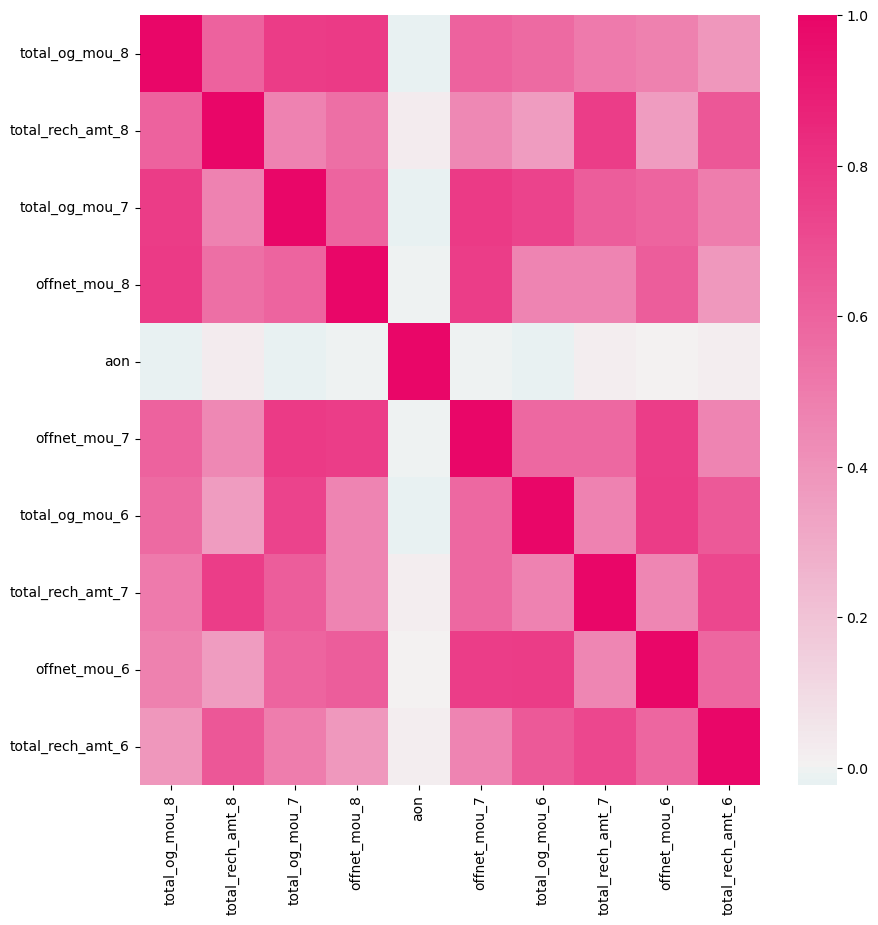

In [248]:
# plot feature correlation
import seaborn as sns
plt.rcParams["figure.figsize"] =(10,10)
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train_top.corr(), center=0.0, cmap=mycmap)

In [249]:
# logistic regression
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [251]:
# fit model
model.fit(X_train_top, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [252]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8197999948147536
Best hyperparameters:  {'logistic__C': 10, 'logistic__penalty': 'l2'}


In [253]:
# predict churn on test data
y_pred = model.predict(X_test_top)

In [254]:
train_score_final = model.score(X_train_top, y_train)
print("Training accuracy:", train_score_final)

Training accuracy: 0.8201866113291147


In [255]:
test_score_final = model.score(X_test_top, y_test)
print("Test accuracy:", test_score_final)

Test accuracy: 0.8167556172094945


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [256]:
confusion_matrix(y_train, model.predict(X_train_top))

array([[29770, 14202],
       [ 1019,  4008]], dtype=int64)

In [257]:
confusion_matrix(y_test, model.predict(X_test_top))

array([[12848,  6047],
       [  455,  1650]], dtype=int64)

In [258]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8197999948147536
Best hyperparameters:  {'logistic__C': 10, 'logistic__penalty': 'l2'}


In [259]:
precision_score(y_test, model.predict(X_test_top))

0.21436923476679226

In [260]:
recall_score(y_test, model.predict(X_test_top))

0.7838479809976246

In [261]:
# check area under curve
y_pred_prob = model.predict_proba(X_test_top)[:, 1]
print("ROC: ", round(roc_auc_score(y_test, y_pred_prob),2))

ROC:  0.82


### Extract the intercept and the coefficients from the logistic model 

In [262]:
logistic_model = model.best_estimator_.named_steps['logistic']

In [263]:
# intercept
intercept_df = pd.DataFrame(logistic_model.intercept_.reshape((1,1)), columns = ['intercept'])

In [264]:
# coefficients
coefficients = logistic_model.coef_.reshape((10, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

logistic_features = list(X_train_top.columns)
coefficients_df = pd.DataFrame(logistic_model.coef_, columns=logistic_features)

In [265]:
# concatenate dataframes
coefficients = pd.concat([intercept_df, coefficients_df], axis=1)
coefficients

,intercept,total_og_mou_8,total_rech_amt_8,total_og_mou_7,offnet_mou_8,aon,offnet_mou_7,total_og_mou_6,total_rech_amt_7,offnet_mou_6,total_rech_amt_6
0,-0.633629,-2.067574,-0.940488,0.843098,0.843933,-0.513268,-0.363604,0.266039,0.010651,-0.096171,0.29623


# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [266]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [267]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 22)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [268]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [269]:
output.to_csv('submission_Satya Prakash_Mythili Kandula.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.